[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)

### based on Fig. 4 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import PySDM
print(PySDM.__file__)

/home/agnieszka/Github/PySDM/PySDM/__init__.py


In [3]:
import numpy as np
from matplotlib import pyplot
import matplotlib.ticker as ticker
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal, Sum
from PySDM.products import (
    ParcelDisplacement, AmbientTemperature, AmbientRelativeHumidity, AmbientDryAirDensity, AmbientWaterVapourMixingRatio
)

from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [4]:
settings_common={
    'dt' : 0.5 * si.s,
    'n_sd_per_mode' : (200,),
    'initial_pressure' : 900 * si.mbar,
    'initial_temperature' : 283 * si.K,
    'initial_relative_humidity' : .97,
    'displacement' : 1000 * si.m,
    'formulae' : Formulae(constants={'MAC': .3})
}
products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
    AmbientTemperature(
        name='T'),
    AmbientDryAirDensity(
        name='rhod'),
    AmbientWaterVapourMixingRatio(
        name='qv'
    )
)

In [5]:
output_POL=np.array([])
output_PRI=np.array([])
legend=[]
for w in [0.25,1,4]:
    settings = Settings(  #pristine
        **settings_common,
        vertical_velocity = w * si.m / si.s,
        aerosol_modes_by_kappa = {
            1.28: Sum((
                Lognormal(norm_factor=125 / si.cm ** 3,m_mode=11 * si.nm,s_geom=1.2),
                Lognormal(norm_factor=65 / si.cm ** 3,m_mode=60 * si.nm,s_geom=1.7)
            ))
        })
    simulation = Simulation(settings, products=products)
    output_PRI = np.append(output_PRI,simulation.run())
    
    settings = Settings(   #polluted
        **settings_common,
        vertical_velocity = w* si.m / si.s,
        aerosol_modes_by_kappa = {
            1.28: Sum((
                Lognormal(norm_factor=160 / si.cm ** 3,m_mode=29 * si.nm,s_geom=1.36),
                Lognormal(norm_factor=380 / si.cm ** 3,m_mode=71 * si.nm,s_geom=1.57)
            ))
        }
    )
    simulation = Simulation(settings, products=products)
    output_POL = np.append(output_POL,simulation.run())
    legend.append(str(w)+' m/s')
    

In [20]:
def rmean(r, n, mask): 
    nt = r.shape[1] #number of timesteps
    rmean = np.full(nt, np.nan)
    n_dot_r =np.multiply(np.array(n),np.where(mask,r,0))
    n_tot = np.sum(np.where(mask, np.array(n), 0), axis=0) 
    nmask = n_tot > 0
    rmean[nmask] = np.sum(n_dot_r[:,nmask], axis=0) / n_tot[nmask]
    return rmean

def radius_std(r, n, mask):
    nt = r.shape[1] #number of timesteps
    n_tot = np.sum(np.where(mask, np.array(n), 0), axis=0) 
    #n_act=np.where(mask, np.array(n), np.nan)
    r_act=np.where(mask, np.array(r), np.nan)
    radius_std=np.full(nt,np.nan)
    for i in range(nt):
        if n_tot[i]>0:
            radius_std[i]=np.std(r_act[:,i][~np.isnan(r_act[:,i])])
            #radius_std[i]=np.sqrt(np.cov(r_act[:,i][~np.isnan(r_act[:,i])], fweights=n_act[:,i][~np.isnan(n_act[:,i])]))
    return radius_std


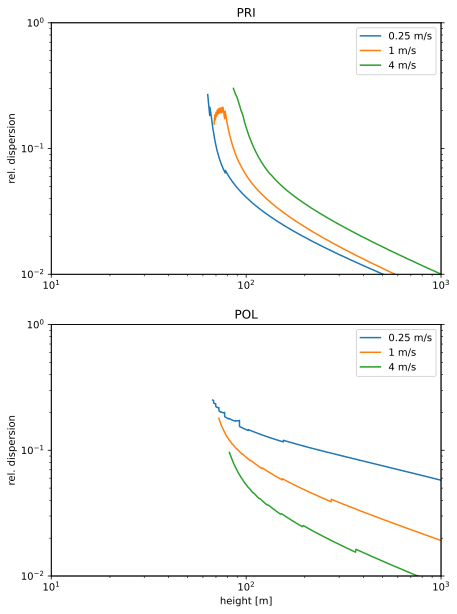

HTML(value="<a href='./fig4.pdf' target='_blank'>./fig4.pdf</a><br>")

In [21]:
fig, axs = pyplot.subplots(2, 1, sharey=False, figsize=(7, 10))

axD1 = axs[0]
for i in range(3):
    r1=rmean(settings.formulae.trivia.radius(volume=np.asarray(output_PRI[i]['attributes']['volume'])), np.array(output_PRI[i]['attributes']['n']), np.asarray(output_PRI[i]['attributes']['volume'])>np.asarray(output_PRI[i]['attributes']['critical volume']))
    d1=radius_std(settings.formulae.trivia.radius(volume=np.asarray(output_PRI[i]['attributes']['volume'])), np.array(output_PRI[i]['attributes']['n']), np.asarray(output_PRI[i]['attributes']['volume'])>np.asarray(output_PRI[i]['attributes']['critical volume']))
    axD1.plot(np.array(output_PRI[i]['products']['z']),np.where(r1*10**6>2,d1/r1,np.nan))

axD2 = axs[1]
for i in range(3):
    r2=rmean(settings.formulae.trivia.radius(volume=np.asarray(output_POL[i]['attributes']['volume'])), np.array(output_POL[i]['attributes']['n']), np.asarray(output_POL[i]['attributes']['volume'])>np.asarray(output_POL[i]['attributes']['critical volume']))
    d2=radius_std(settings.formulae.trivia.radius(volume=np.asarray(output_POL[i]['attributes']['volume'])), np.array(output_POL[i]['attributes']['n']), np.asarray(output_POL[i]['attributes']['volume'])>np.asarray(output_POL[i]['attributes']['critical volume']))
    axD2.plot(np.array(output_POL[i]['products']['z']),np.where(r2*10**6>2,d2/r2,np.nan))

for ax in [axD1,axD2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0.01,1)
    ax.set_xlim(10,1000)
    ax.set_ylabel('rel. dispersion')
    ax.legend(legend)
axD2.set_xlabel('height [m]')
axD1.set_title('PRI')
axD2.set_title('POL')

axD1_ = axD1.twinx() 
axD2_ = axD2.twinx()
for ax in [axD1_,axD2_]:
    ax.set_yscale('log')
    ax.set_ylim(0.01,1)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot("fig4.pdf")